# Modeling Using XGBoost

Now that I have the function that preprocesses the data, I will move on to making the XGBoost model and training it on the dataset

## Imports

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import xgboost as xgb

### Load the Data and Process it

In [2]:
def train_test_from_raw_data(dataset):
    dataset.columns = [col.replace(".",'_') for col in dataset.columns]
    dataset = dataset.drop('fnlwgt', axis=1)
    dataset.replace('?', np.nan, inplace=True)
    
    dataset.dropna(inplace=True)
    
    features = dataset.drop('income', axis=1)
    target = dataset['income']
    
    features = pd.get_dummies(features)
    target = target.map({
        '<=50K': 0,
        '>50K': 1
    })
    
    return train_test_split(features, target, test_size = 0.2, stratify = target)

In [3]:
dataset = pd.read_csv("../data/adult_raw.csv")

x_train, x_test, y_train, y_test = train_test_from_raw_data(dataset)

### Make the Base XGBoost model and fit it to the data

In [4]:
base_model = xgb.XGBClassifier()
base_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

### Make Predictions

In [5]:
y_hat = base_model.predict(x_test)
y_prob = base_model.predict_proba(x_test)[:, 1]

### Get the Metrics of the Result

In [6]:
print('Confusion Matrix:\n', confusion_matrix(y_pred= y_hat, y_true= y_test))
print('\n\n\nClassification Report:\n', classification_report(y_pred= y_hat, y_true= y_test))

Confusion Matrix:
 [[4230  301]
 [ 530  972]]



Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      4531
           1       0.76      0.65      0.70      1502

    accuracy                           0.86      6033
   macro avg       0.83      0.79      0.81      6033
weighted avg       0.86      0.86      0.86      6033



### Plot the ROC Curve

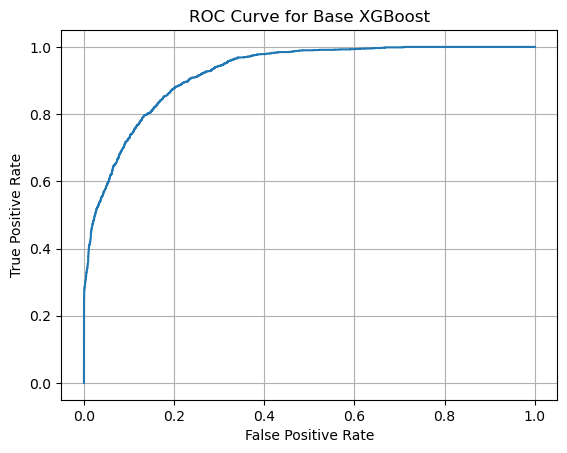

ROC-AUC score:  0.9230994442486895


In [7]:
false_pos_rate, true_pos_rate, threshold = roc_curve(y_score= y_prob, y_true= y_test)

plt.plot(false_pos_rate, true_pos_rate, label="ROC Curve")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC Curve for Base XGBoost")
plt.grid()
plt.show()

print("ROC-AUC score: ", roc_auc_score(y_score= y_prob, y_true= y_test))

### Make the XGBoost model while taking Target Imbalance into Consideration

In [8]:
neg_pos_ratio = (len(y_train) - y_train.sum()) / y_train.sum()
new_model = xgb.XGBClassifier(scale_pos_weight = neg_pos_ratio)
new_model.fit(x_train, y_train)

y_hat = new_model.predict(x_test)
y_prob = new_model.predict_proba(x_test)[:, 1]


print('Confusion Matrix:\n', confusion_matrix(y_pred= y_hat, y_true= y_test))
print('\n\n\nClassification Report:\n', classification_report(y_pred= y_hat, y_true= y_test))

Confusion Matrix:
 [[3744  787]
 [ 228 1274]]



Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.83      0.88      4531
           1       0.62      0.85      0.72      1502

    accuracy                           0.83      6033
   macro avg       0.78      0.84      0.80      6033
weighted avg       0.86      0.83      0.84      6033



### ROC Curve

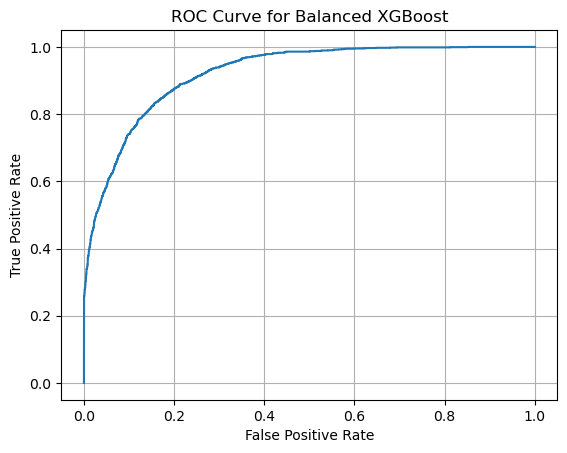

ROC-AUC score:  0.9224355020202593


In [9]:
false_pos_rate, true_pos_rate, threshold = roc_curve(y_score= y_prob, y_true= y_test)

plt.plot(false_pos_rate, true_pos_rate)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC Curve for Balanced XGBoost")
plt.grid()
plt.show()

print("ROC-AUC score: ", roc_auc_score(y_score= y_prob, y_true= y_test))

---
## Understanding the Model
Now that we have our models, I want to know what the models found to be most important

We will discuss understanding the model more later on, especially when discussing **SHAP**

For now let us plot the top 10 features the model found to be most important, otherwise it would get too cluttered

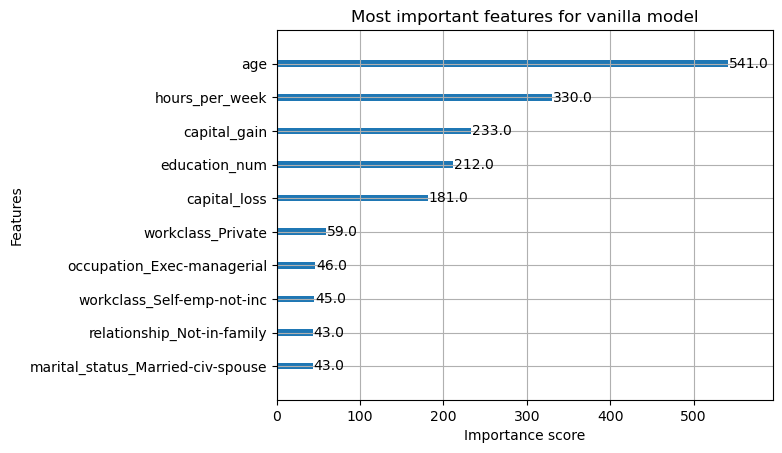

In [10]:
xgb.plot_importance(base_model, max_num_features=10)
plt.title("Most important features for vanilla model")
plt.show()

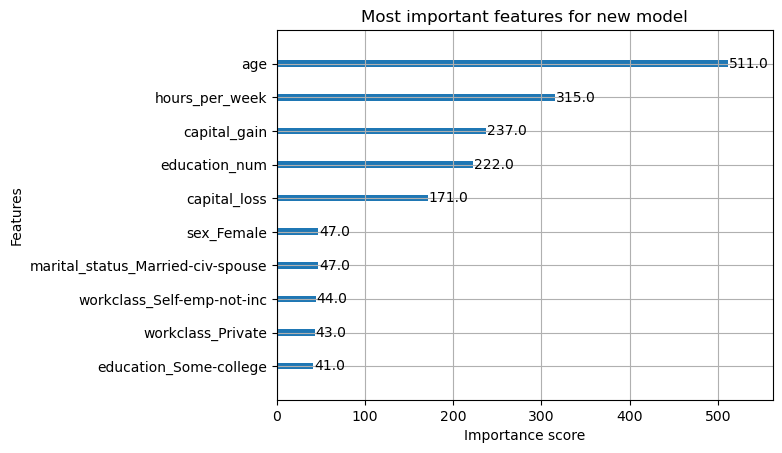

In [11]:
xgb.plot_importance(new_model, max_num_features=10)
plt.title("Most important features for new model")
plt.show()

## Conclusions
### Classification Reports
#### Unweighted Model
- Significantly higher precision for income >50K
- Higher recall for income <=50K
- Higher accuracy

#### Weighted Model
- Significantly higher recall for income >50K
- Higher precision for income <=50K

It seems that the Unweighted Model performs better as a general model, with a better accuracy and almost negligibly better F1 and ROC-AUC scores

---

### ROC Curve and ROC-AUC scores
Both models are almost identical when it comes to the ROC curve and ROC-AUC score

---

### Feature Importance
- It seems that both models found age to be the most important feature, and by a huge difference.
- The importance score drops significantly after the first 5 features
- Most of the order for the top 5 features is the same for both models